In [2]:
from abc import ABC, abstractmethod
import numpy as np
import nnfs
import matplotlib.pyplot as plt
import seaborn as sns
from nnfs.datasets import spiral_data
nnfs.init()

# Single Neuron

In [3]:
class NeuronNode:
    def __init__(self, dim):
        self.dim = dim
        self.weights = [0] * dim
        self.bias = 0
    
    def trigger(self, inputs):
        if len(inputs) != len(self.weights): raise ValueError("Invalid Input length")
        return np.dot(self.weights, inputs) + self.bias # dot(Input, Weight) + bias

# Activation Functions

In [4]:
class ActivationFunction(ABC):
    @abstractmethod
    def calculate(self, x):
        pass
    
    @abstractmethod
    def backpropagate(self, x):
        pass

In [5]:
class StepFunction(ActivationFunction):
    def calculate(self, x):
        return x > 0
    
    def backpropagate(self, x):
        return 1

In [6]:
class LinearFunction(ActivationFunction):
    def calculate(self, x):
        return x
    
    def backpropagate(self, x):
        return 1

In [7]:
class SigmoidFunction(ActivationFunction):
    def calculate(self, x):
        return 1 / (1 + np.exp(-x))
    
    def backpropagate(self, x):
        return self.calculate(x) * (1 - self.calculate(x))

In [8]:
class ReLUFunction(ActivationFunction):
    def calculate(self, x):
        return np.maximum(x, 0)

    def backpropagate(self, x):
        return 1

In [9]:
class SoftMaxFunction(ActivationFunction):
    def calculate(self, x):
        norm = np.exp(x - np.max(x, axis=1, keepdims=True))
        prob = norm / np.sum(norm, axis=1, keepdims=True)
        return prob

    def backpropagate(self, x):
        s = self.calculate(x)
        d = np.zeros((len(s), len(s)))

        for i in range(len(s)):
            for j in range(len(s)):
                d[i, j] = s[i] * ((i == j) - s[j])
        return d

# Loss Functions

In [10]:
class LossFunction(ABC):
    @abstractmethod
    def calculate(self, y_true, y_pred):
        pass
    
    @abstractmethod
    def backpropagate(self, y_true, y_pred):
        pass

In [11]:
class Categorical_Cross_Entropy(LossFunction):
    def calculate(self, y_true, y_pred):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 + 1e-7)

        conf = np.sum(y_pred_clipped * y_true,
            axis=1) if len(y_true.shape) == 2 else y_pred_clipped[range(samples), y_true]
        return np.mean(-np.log(conf))

    def backpropagate(self, y_true, y_pred):
        return y_pred - y_true

# Metric Calculations

In [12]:
def accuracy(y_true, y_pred):
    if len(y_true.shape) > 1:
        y_true = y_true.flatten()
    y_pred_classes = np.argmax(y_pred, axis=1)
    return np.mean(y_true == y_pred_classes)

# Neural Network with a forward pass

## NN made of Neuron Class

This neural network is made of several units of NeuronNode

In [23]:
class NeuralNetwork:
    def __init__(self, act_fun = ReLUFunction()):
        self.act_fun = act_fun
        self.layers = []
    
    def add_layer(self, neurons):
        self.layers.append(neurons)
    
    def forward(self, inputs):
        current_input = inputs
        current_level = 0
        curr_output = [] * len(self.layers[0])

        while current_level < len(self.layers):
            curr_layer = self.layers[current_level]
            if any(len(current_input) != neuron.dim for neuron in curr_layer):
                raise Exception('Dimension mismatch')
            curr_output = [self.act_fun.calculate(neuron.trigger(current_input)) for neuron in curr_layer]
            current_input = curr_output
            current_level += 1
        else:
            return curr_output

## NN as layers of weight matrices

This neural network is made using weight matrices
1. A weight matrix exists for each layer
2. The dimension of the weight matrix is no of neurons * input dim

In [24]:
class NeuralNetwork:
    def __init__(self, act_fun = ReLUFunction()):
        self.act_fun = act_fun
        self.layers = []
        self.neural_structure = []
    
    def add_layer(self, weight_mat, biases):
        if len(biases) != len(weight_mat) or any(len(weight_mat[i]) != len(weight_mat[0])
            for i in range(1, len(weight_mat))):
            raise Exception("Dimension Invalid")
        
        self.neural_structure.append({
            "neurons": weight_mat.shape[0],
            "input_dim": weight_mat.shape[1],
            "output_dim": weight_mat.shape[0]
            })
        
        self.layers.append((weight_mat, biases))
    
    def single_forward(self, input):
        current_layer = 0
        current_input = input
        current_output = []

        while current_layer < len(self.layers):
            layer = self.layers[current_layer]  # current weight_matrix
            weights, biases = layer
            
            if len(current_input)!= biases:
                raise Exception("Invalid Dimension")
            
            current_output = self.act_fun.calculate(np.dot(weights, current_input) + biases)
            current_layer += 1
            current_input = current_output
        return current_output
    
    def batch_forward(self, input_batch):
        # dim of input_batch is batch_size * input_vector_dim
        current_layer = 0
        current_input_batch = input_batch
        current_output = []

        while current_layer < len(self.layers):
            layer = self.layers[current_layer]  # current weight_matrix
            weights, biases = layer
            
            if weights.shape[0] != biases.shape[0]:
                raise Exception("Invalid Dimension")
            
            current_output = self.act_fun(np.dot(weights.T, current_input_batch) + biases)
            current_layer += 1
            current_input_batch = current_output
        return current_output  # dim: batch_size * output_vector_dim

## Composing NN as NeuronLayers

Converting a neuron layer into a class itself

In [15]:
class NeuronLayer:
    def __init__(self, input_dim, n_neuron, weights = None, biases = None):
        self.input_dim = input_dim
        self.n_neuron = n_neuron
        self.weights = 0.01 * np.random.randn(input_dim, n_neuron) if not weights else weights
        self.biases = np.zeros((1, n_neuron)) if not biases else biases
    
    def single_forward(self, input_vec):
        if input_vec.shape[0] != self.weights.shape[0]: raise Exception("Incorrect input Dimensions")

        return np.dot(input_vec, self.weights) + self.biases
    
    def batch_forward(self, input_batch):
        if input_batch.shape[1] != self.weights.shape[0]:   raise Exception("Incorrect input Dimensions")

        return np.dot(input_batch, self.weights) + self.biases

In [25]:
class NeuralNetwork:
    def __init__(self, act_fun = ReLUFunction()):
        self.act_fun = act_fun
        self.neural_arch = []
        self.layers = []
    
    def add_layer(self, input_dim, n_neuron, weights = None, biases = None):
        layer = NeuronLayer(input_dim, n_neuron)
        self.layers.append(layer)
        self.neural_arch.append({
            "n_neuron": layer.n_neuron,
            "input_dim": layer.input_dim
        })
    
    def single_forward(self, input_vec):
        current_layer = 0
        current_input, current_output = input_vec, []

        while current_layer < len(self.layers):
            layer = self.layers[current_layer]
            current_output = self.act_fun(layer.single_forward(current_input))
            current_input = current_output
            current_layer += 1
        return current_output
    
    def batch_forward(self, input_batch):
        current_layer = 0
        current_input, current_output = input_batch, []

        while current_layer < len(self.layers):
            layer = self.layers[current_layer]
            current_output = self.act_fun.calculate(layer.batch_forward(current_input))
            current_layer += 1
            current_input = current_input
        return current_output

# Neural Network with Backpropagation

In [ ]:
class NeuronLayer:
    def __init__(self, input_dim, n_neuron, weights = None, biases = None):
        self.input_dim = input_dim
        self.inputs = None
        self.n_neuron = n_neuron
        self.weights = 0.01 * np.random.randn(input_dim, n_neuron) if not weights else weights
        self.biases = np.zeros((1, n_neuron)) if not biases else biases
    
    def forward(self, input_vec):
        if (len(input_vec) == 1 and input_vec.shape[0] != self.weights.shape[0]) or (
            len(input_vec) > 1 and input_vec.shape[1] != self.weights.shape[0]):
            raise Exception("Incorrect input Dimensions")
        
        self.inputs = input_vec
        return np.dot(input_vec, self.weights) + self.biases
    
    def backpropagate(self):
        #       in_dim * nn, bsize * in_dim
        return [self.weights, self.inputs, 1]  # dZ/dI, dZ/dW, dZ/db

In [40]:
class NeuralNetwork:
    def __init__(self, act_fun = ReLUFunction(), loss_fun = Categorical_Cross_Entropy()):
        self.act_fun = act_fun
        self.loss_fun = loss_fun
        self.neural_arch = []
        self.layers = []
        self.input, self.output = None, None
        self.outer_fun = None
    
    def add_layer(self, input_dim, n_neuron, weights = None, biases = None, act_fun=None):
        layer = NeuronLayer(input_dim, n_neuron, weights, biases)
        self.layers.append(layer)
        self.neural_arch.append({
            "n_neuron": layer.n_neuron,
            "input_dim": layer.input_dim
        })

        if act_fun:
            self.outer_fun = act_fun
    
    def forward(self, input_batch):
        current_layer = 0
        current_input, current_output = input_batch, []

        if self.outer_fun:
            while current_layer < len(self.layers) - 1:
                layer = self.layers[current_layer]
                current_output = self.act_fun.calculate(layer.forward(current_input))
                current_input = current_output
                current_layer += 1
            else:
                layer = self.layers[current_layer]
                current_output = self.outer_fun.calculate(layer.forward(current_input))
        else:
            while current_layer < len(self.layers):
                layer = self.layers[current_layer]
                current_output = self.act_fun.calculate(layer.forward(current_input))
                current_input = current_output
                current_layer += 1
        
        self.input, self.output = input_batch, current_output
        return current_output
    
    def score(self, input_batch, y_true, metric = accuracy):
        y_pred = self.batch_forward(input_batch)
        return metric(y_true, y_pred)

    def backpropagate(self, y_true):
        # all layers bp
        layers_bp = [layer.backpropagate() for layer in self.layers]

        last_layer = self.layers[-1]
        last_layer_bp = layers_bp[-1]
        y_pred = last_layer.output

        # loss layer bp
        d_loss = self.loss_fun.backpropagate(y_true, y_pred)
        total_bp = d_loss * last_layer_bp

        # traverse hidden layer bp
        current_layer = len(self.layers) - 2
        k = 3
        while current_layer != -1:
            layer = self.layers[current_layer]
            d_act = self.act_fun.backpropagate(layer.output)
            layer_bp = layers_bp[current_layer]
            
            total_bp += total_bp[k-3] * 1 * d_act * layer_bp

            k += 3
            current_layer -= 1

        return total_bp

# Read from Dataset

In [27]:
# TODO: read a csv file of data points for this

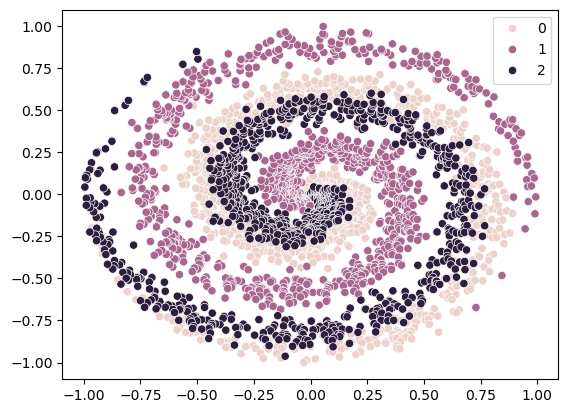

In [28]:
X, y = spiral_data(samples=1000, classes=3)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.show()

In [ ]:
nn = NeuralNetwork(loss_fun=Categorical_Cross_Entropy())
nn.add_layer(2, 3)
nn.add_layer(3, 3)

In [ ]:
classifying_layer = NeuronLayer(3, 3)
def classify(inputs):
    return SoftMaxFunction().calculate(classifying_layer.batch_forward(nn.batch_forward(inputs)))

In [31]:
# output = nn.batch_forward(X)
output = classify(X)

In [ ]:
Categorical_Cross_Entropy(y_true=y, y_pred=output)

np.float32(1.0986005)

In [75]:
accuracy(y, output)

np.float64(0.35533333333333333)